In [1]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
from tqdm import tqdm
import random
import numpy as np
import cv2
from torch.nn.functional import pairwise_distance
import shutil
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
shutil.copytree("/kaggle/input/siamese1/Siamese", "/kaggle/working/Siamese", dirs_exist_ok=True)


'/kaggle/working/Siamese'

In [3]:
shutil.move("/kaggle/working/Siamese/personA/Test/personA_30.png", "/kaggle/working/Siamese/personA/Train/personA_30.png")

'/kaggle/working/Siamese/personA/Train/personA_30.png'

In [4]:
shutil.move("/kaggle/working/Siamese/personA/Train/personA_33.png", "/kaggle/working/Siamese/personA/Test/personA_33.png")

'/kaggle/working/Siamese/personA/Test/personA_33.png'

In [5]:
# prepare the dataset, iterate over each folder (personA : personB) in each folder there is test and train, read csv in each one and split images into two folders, real & fake
def prepare_dataset(base_path):
    for folder in os.listdir(base_path):
        path = os.path.join(base_path, folder)
        if os.path.isdir(path):
            train_path = os.path.join(path, 'Train')
            test_path = os.path.join(path, 'Test')
            # Create real and forged folders in train path
            os.makedirs(os.path.join(train_path, 'real'), exist_ok=True)
            os.makedirs(os.path.join(train_path, 'forged'), exist_ok=True)
            for file in os.listdir(train_path):
                if file.endswith('.csv'): 
                    df = pd.read_csv(os.path.join(train_path, file))
                    for index, row in df.iterrows():
                        img_path = os.path.join(train_path, row['image_name'])
                        if os.path.exists(img_path):
                            if row['label'] == 'real':
                                shutil.copy(img_path, os.path.join(train_path, 'real', row['image_name']))
                            else:
                                shutil.copy(img_path, os.path.join(train_path, 'forged', row['image_name']))
                        else:
                            print(f"Image {img_path} does not exist.")
                else:
                    # If the file is not a CSV, skip it
                    continue
            # Create real and forged folders in test path
            os.makedirs(os.path.join(test_path, 'real'), exist_ok=True)
            os.makedirs(os.path.join(test_path, 'forged'), exist_ok=True)
            for file in os.listdir(test_path):
                if file.endswith('.csv'):
                    df = pd.read_csv(os.path.join(test_path, file))
                    for index, row in df.iterrows():
                        img_path = os.path.join(test_path, row['image_name'])
                        if os.path.exists(img_path):
                            if row['label'] == 'real':
                                shutil.copy(img_path, os.path.join(test_path, 'real', row['image_name']))
                            else:
                                shutil.copy(img_path, os.path.join(test_path, 'forged', row['image_name']))
                        else:
                            print(f"Image {img_path} does not exist.")
                else:
                    # If the file is not a CSV, skip it
                    continue
# Load and preprocess the dataset
prepare_dataset("/kaggle/working/Siamese")


In [6]:
# create a function to load train triplets, create all possible triplets, and append them to a list,
# ensuring anchor, positive, and negative images are different
# number of triplets = number of forged images * (number of real C 2)
def load_triplets(base_path,set_type):
    triplets = []
    for folder in os.listdir(base_path):
        path = os.path.join(base_path, folder)
        if os.path.isdir(path):
            set_path = os.path.join(path, set_type)
            real_path = os.path.join(set_path, 'real')
            forged_path = os.path.join(set_path, 'forged')
            real_images = os.listdir(real_path)
            forged_images = os.listdir(forged_path)
            # Create all possible triplets
            for i in range(len(real_images)):
                for j in range(len(real_images)):
                    for k in range(len(forged_images)):
                        if j>i:
                            triplet = (os.path.join(real_path, real_images[i]), os.path.join(real_path, real_images[j]), os.path.join(forged_path, forged_images[k]))
                            triplets.append(triplet)
    return triplets
# Load the dataset
train_triplets = load_triplets("/kaggle/working/Siamese", "Train")
test_triplets = load_triplets("/kaggle/working/Siamese", "Test")
print(f"Number of training triplets: {len(train_triplets)}")
print(f"Number of testing triplets: {len(test_triplets)}")
            

Number of training triplets: 19000
Number of testing triplets: 120


In [7]:
class TripletDataset(Dataset):
    def __init__(self, triplets,transform=None):
        self.triplets = triplets 
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, index):
        anchor_path, positive_path, negative_path = self.triplets[index]

        anchor = Image.open(anchor_path).convert('RGB')
        positive = Image.open(positive_path).convert('RGB')
        negative = Image.open(negative_path).convert('RGB')

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

In [8]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = TripletDataset(train_triplets, transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 29 * 29, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)
        )

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, anchor, positive, negative):
        out_anchor = self.forward_one(anchor)
        out_positive = self.forward_one(positive)
        out_negative = self.forward_one(negative)
        return out_anchor, out_positive, out_negative

In [10]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        d_pos = torch.nn.functional.pairwise_distance(anchor, positive)
        d_neg = torch.nn.functional.pairwise_distance(anchor, negative)
        loss = torch.mean(torch.relu(d_pos - d_neg + self.margin))
        return loss

In [11]:
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
criterion = TripletLoss(margin=1.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (anchor, positive, negative) in progress_bar:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()
        out_anchor, out_positive, out_negative = model(anchor, positive, negative)
        loss = criterion(out_anchor, out_positive, out_negative)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/1: 100%|██████████| 1188/1188 [04:34<00:00,  4.33it/s, loss=0]       

Epoch [1/1], Avg Loss: 0.0625


In [12]:
dataset = TripletDataset(test_triplets, transform=transform)
test_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [13]:
## model.eval()
correct = 0
total = 0

with torch.no_grad():
    for i, (anchor, positive, negative) in enumerate(tqdm(test_loader, desc="Testing")):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        out_anchor, out_positive, out_negative = model(anchor, positive, negative)

        # Calculate distances
        d_pos = pairwise_distance(out_anchor, out_positive)
        d_neg = pairwise_distance(out_anchor, out_negative)

        # Count as correct if d_pos < d_neg
        correct += (d_pos < d_neg).sum().item()
        total += anchor.size(0)

accuracy = correct / total * 100
print(f"\nTest Accuracy: {accuracy:.2f}%")

Testing: 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]


Test Accuracy: 82.50%


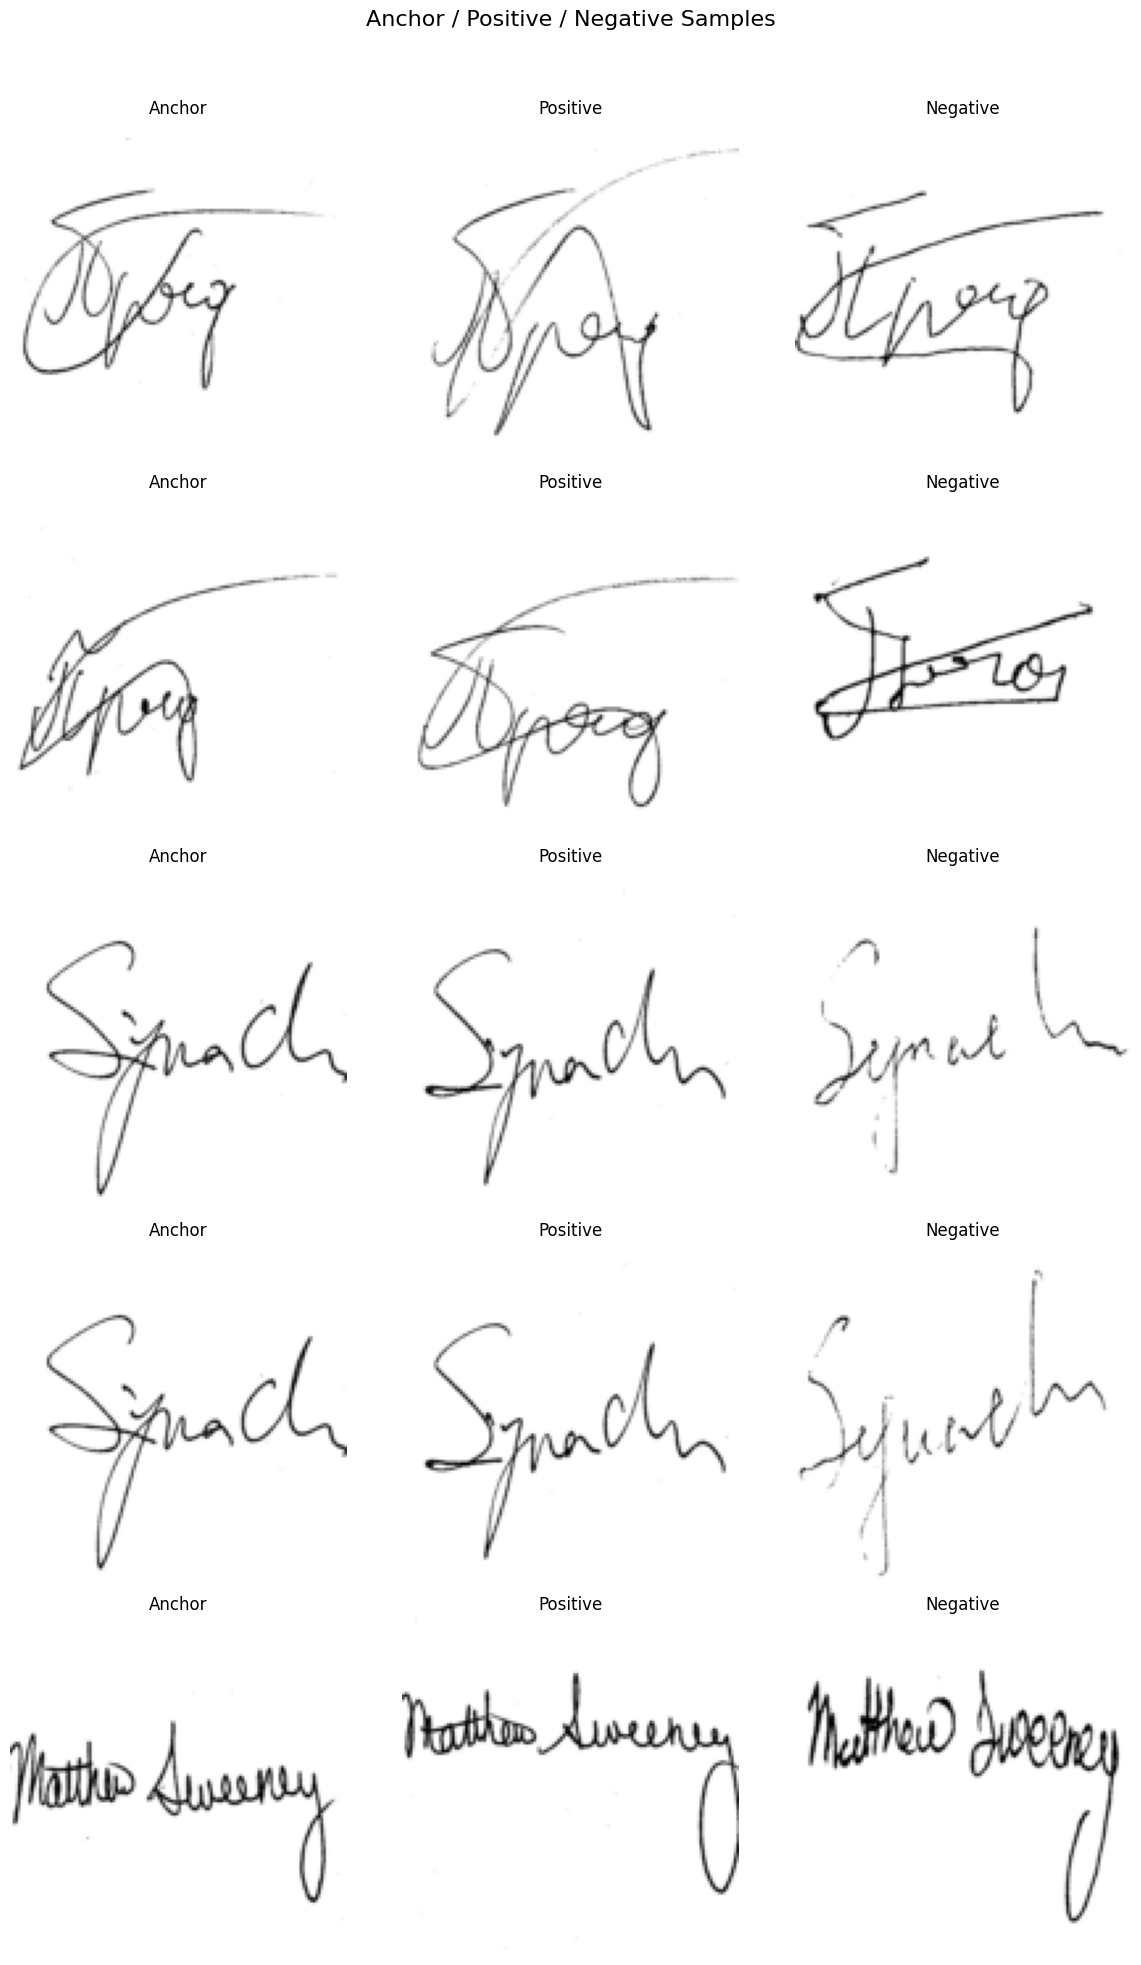

In [21]:
import random
def visualize_triplets(dataset, num_samples=5):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    fig.suptitle("Anchor / Positive / Negative Samples", fontsize=16)
    
    for i in range(num_samples):
        j = random.randint(0,120)
        anchor, positive, negative = dataset[j]
        
        # Convert tensors to numpy arrays for visualization
        anchor_img = anchor.permute(1, 2, 0).numpy()
        positive_img = positive.permute(1, 2, 0).numpy()
        negative_img = negative.permute(1, 2, 0).numpy()
        
        # Plot anchor
        axes[i, 0].imshow(anchor_img)
        axes[i, 0].set_title("Anchor")
        axes[i, 0].axis("off")
        
        # Plot positive
        axes[i, 1].imshow(positive_img)
        axes[i, 1].set_title("Positive")
        axes[i, 1].axis("off")
        
        # Plot negative
        axes[i, 2].imshow(negative_img)
        axes[i, 2].set_title("Negative")
        axes[i, 2].axis("off")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize triplets from the training dataset
visualize_triplets(dataset, num_samples=5)